In [1]:
import pandas as pd 

In [2]:
splice_data = pd.read_table("canonical_dataset.txt", header=None, names=['gene', 
                                                                         'has_paralogs',
                                                                         'chrom',
                                                                         'strand', 
                                                                         'start',
                                                                         'end',
                                                                         'splice_starts',
                                                                         'splice_ends'])

In [3]:
splice_data = splice_data[splice_data.has_paralogs == 0]
TEST_CHROMS = ['chr1', 'chr3', 'chr5', 'chr7', 'chr9']
splice_data = splice_data[splice_data['chrom'].isin(TEST_CHROMS)]

In [4]:
splice_data['splice_starts'] = splice_data['splice_starts'].str.split(',').apply(lambda x: [int(k) for k in x if k])
splice_data['splice_ends'] = splice_data['splice_ends'].str.split(',').apply(lambda x: [int(k) for k in x if k])

In [5]:
with open("genes.txt", 'r') as inp:
    genes = set(line.strip() for line in inp)

In [6]:
splice_data = splice_data[splice_data['gene'].isin(genes)]

In [7]:
from Bio import SeqIO 
genome = SeqIO.to_dict(SeqIO.parse("hg19.fa", format="fasta"))

In [8]:
splice_sites = []
step = (5000 + 10000 - 2) // 2

for ind, row in splice_data.iterrows():

    for don in row.splice_starts:
        if row.strand == "+":
            tp = "donor"
            #print(str(genome[row.chrom][don:don+2].seq.upper()))
            seq = str(genome[row.chrom][don-step:don+2+step].seq.upper())
        else:
            tp = "acceptor"
            #print(str(genome[row.chrom][don:don+2].seq.upper().reverse_complement()))
            seq = str(genome[row.chrom][don-step:don+2+step].seq.upper().reverse_complement())
        new_row = {"gene": row.gene, "type": tp, "seq": seq}
        splice_sites.append(new_row)
    
    for ac in row.splice_ends:
        if row.strand == "+":
            tp = "acceptor"
            #print(str(genome[row.chrom][ac-3:ac-1].seq.upper()))
            seq = str(genome[row.chrom][ac-3-step:ac-1+step].seq.upper())
        else:
            tp = "donor"
            #print(str(genome[row.chrom][ac-3:ac-1].seq.upper().reverse_complement()))
            seq = str(genome[row.chrom][ac-3-step:ac-1+step].seq.upper().reverse_complement())

        new_row = {"gene": row.gene, "type": tp, "seq": seq}
        splice_sites.append(new_row)
            
    


In [9]:
splice_df = pd.DataFrame(splice_sites)

In [10]:
splice_df.shape

(1862, 3)

In [11]:
import torch
from transformers import AutoConfig, AutoTokenizer
from transformers import BigBirdForTokenClassification


In [12]:
model_cfg = AutoConfig.from_pretrained("splice_cfgs/hf_bigbird_L12-H768-A12-V32k-L4096.json")
model_cfg.num_labels = 3
model_cfg.problem_type = 'multi_label_classification'
model_cls = BigBirdForTokenClassification
model = model_cls(config=model_cfg)

# load weights
checkpoint = torch.load("splice_checks/model_best.pth", map_location='cpu')
missing_k, unexpected_k = model.load_state_dict(checkpoint["model_state_dict"], strict=False)
if len(missing_k) != 0:
    print(f'{missing_k} were not loaded from checkpoint! These parameters were randomly initialized.')
if len(unexpected_k) != 0:
    print(f'{unexpected_k} were found in checkpoint, but model is not expecting them!')

# run eval mode
model.eval()

BigBirdForTokenClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=3)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0): BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        

In [13]:
tokenizer = AutoTokenizer.from_pretrained("splice_toks/t2t_1000h_multi_32k/")

In [14]:
device = torch.device("cuda:0")
model = model.to(device)

In [15]:
def dict2device(X, device):
    return {key: val.to(device) for key, val in X.items()}


In [16]:
import numpy as np 
from torch.utils.data import Dataset


class SpliceAIPredictDataset(Dataset):
    def __init__(
        self,
        df,
        tokenizer,
        center_dist, 
        mut_shift,
        max_seq_len=4096,
        targets_offset=5000,
        targets_len=5000,
    ):
        assert abs(center_dist) >= 0
        assert mut_shift >= -1 and mut_shift <3
        
        self.data = df
        self.tokenizer = tokenizer
        self.center_dist = center_dist
        self.mut_shift = mut_shift
        self.max_seq_len = max_seq_len
        self.targets_offset = targets_offset
        self.targets_len = targets_len
        

    def __len__(self):
        return len(self.data)

    @staticmethod
    def get_token_classes(seq_encoding, target, targets_offset):
        tokens_info = pd.DataFrame.from_records(
            seq_encoding["offset_mapping"][0], columns=["st", "en"]
        )
        tokens_info["length"] = tokens_info["en"] - tokens_info["st"]

        # handle special tokens which can be anywhere in the seq with the offeset (0,0)
        nonzero_length_mask = tokens_info["length"].values > 0

        # all other tokens should have ascending token_start coordinate
        assert np.all(
            tokens_info[nonzero_length_mask]["st"].values[:-1]
            <= tokens_info[nonzero_length_mask]["st"].values[1:]
        )

        # fill target class information
        target_field_names = []
        for target_class in [1, 2]:
            target_field_name = "class_" + str(target_class)
            target_field_names.append(target_field_name)
            tokens_info[target_field_name] = 0

            nonzero_target_positions = (
                np.where(target == target_class)[0] + targets_offset
            )  # non-zero target coordinates
            nonzero_target_token_ids = (
                np.searchsorted(
                    tokens_info[nonzero_length_mask]["st"],
                    nonzero_target_positions,
                    side="right",
                )
                - 1
            )  # ids of tokens
            # containing non-zero targets
            # in sequence coordinate system
            nonzero_target_token_ids = (
                tokens_info[nonzero_length_mask].iloc[nonzero_target_token_ids].index
            )
            tokens_info.loc[nonzero_target_token_ids, target_field_name] = target_class
            # tokens_info.loc[nonzero_target_token_ids, target_field_name] = 1
            # fill all service tokens with -100
            tokens_info.loc[~nonzero_length_mask, target_field_name] = -100

            # fill context tokens with -100
            target_first_token = (
                np.searchsorted(
                    tokens_info[nonzero_length_mask]["st"],
                    targets_offset,
                    side="right",
                )
                - 1
            )

            mask_ids = (
                tokens_info.loc[nonzero_length_mask, :].iloc[:target_first_token].index
            )
            tokens_info.loc[mask_ids, target_field_name] = -100

            target_last_token = (
                np.searchsorted(
                    tokens_info[nonzero_length_mask]["st"],
                    targets_offset + len(target) - 1,
                    side="right",
                )
                - 1
            )
            if target_last_token + 1 < len(
                tokens_info.loc[nonzero_length_mask, target_field_name]
            ):
                target_last_token += 1
                mask_ids = tokens_info.loc[nonzero_length_mask, :][target_last_token:].index
                tokens_info.loc[mask_ids, target_field_name] = -100
        return tokens_info[target_field_names].values

    def tokenize_inputs(self, seq):
        depad_seq_l = seq.lstrip("N")
        if self.targets_offset - (len(seq) - len(depad_seq_l)) < 0:
            depad_seq_l = seq[self.targets_offset:]
        targets_offset = self.targets_offset - (len(seq) - len(depad_seq_l))
        assert targets_offset >= 0
        assert targets_offset + self.targets_len <= len(depad_seq_l)

        depad_seq_both = depad_seq_l.strip("N")
        if targets_offset + self.targets_len > len(depad_seq_both):
            seq = depad_seq_l[:targets_offset + self.targets_len]
        else:
        	seq = depad_seq_both

        left, mid, right = (
            seq[:targets_offset],
            seq[targets_offset : targets_offset + self.targets_len],
            seq[targets_offset + self.targets_len :],
        )

        mid_encoding = self.tokenizer(
            mid,
            add_special_tokens=False,
            padding=False,
            return_offsets_mapping=True,
            return_tensors="np",
        )
        context_encoding = self.tokenizer(
            left + "X" + right,
            add_special_tokens=False,
            padding=False,
            return_offsets_mapping=True,
            return_tensors="np",
        )

        for encoding in [mid_encoding, context_encoding]:
            assert np.all(encoding["attention_mask"][0] == 1)
            assert np.all(encoding["token_type_ids"][0] == 0)

        token_type_ids = np.zeros(shape=self.max_seq_len, dtype=np.int64)

        boundary_pos = int(
            np.where(
                context_encoding["offset_mapping"][0] == [len(left), len(left) + 1]
            )[0][0]
        )
        boundary_token = context_encoding["input_ids"][0][boundary_pos].tolist()
        assert (
            self.tokenizer.convert_ids_to_tokens(boundary_token) == "[UNK]"
        ), "Error during context tokens processing"

        n_service_tokens = 4  # CLS-left-SEP-mid-SEP-right-SEP (PAD)

        L_mid = len(mid_encoding["input_ids"][0])
        L_left = boundary_pos
        L_right = len(context_encoding["token_type_ids"][0]) - L_left - 1

        
        # case I. target's encoding >= max_seq_len; don't add context & trim target if needed
        if L_mid + n_service_tokens >= self.max_seq_len:
            # st = (L_mid // 2) - (self.max_seq_len - n_service_tokens) // 2
            # en = st + (self.max_seq_len - n_service_tokens)
            st = 0
            en = self.max_seq_len - n_service_tokens

            input_ids = np.concatenate(
                [
                    [
                        self.tokenizer.convert_tokens_to_ids("[CLS]"),
                        self.tokenizer.convert_tokens_to_ids("[SEP]"),
                    ],
                    mid_encoding["input_ids"][0][st:en],
                    [self.tokenizer.convert_tokens_to_ids("[SEP]")] * 2,
                ]
            )
            mask = np.concatenate(
                [
                    [
                        False, False
                    ],
                    np.ones(shape=(en-st, ), dtype=bool),
                    [False, False],
                ]
            )
           
        # case II. target+context encoding < max_seq_len, we need to pad
        elif L_mid + L_left + L_right + n_service_tokens <= self.max_seq_len:
            n_pads = self.max_seq_len - (L_mid + L_left + L_right + n_service_tokens)
            input_ids = np.concatenate(
                [
                    [self.tokenizer.convert_tokens_to_ids("[CLS]")],
                    context_encoding["input_ids"][0][:boundary_pos],
                    [self.tokenizer.convert_tokens_to_ids("[SEP]")],
                    mid_encoding["input_ids"][0],
                    [self.tokenizer.convert_tokens_to_ids("[SEP]")],
                    context_encoding["input_ids"][0][boundary_pos + 1:],
                    [self.tokenizer.convert_tokens_to_ids("[PAD]")] * n_pads,
                    [self.tokenizer.convert_tokens_to_ids("[SEP]")],
                ]
            )
            mask = np.concatenate(
                [
                    [
                        False,
                    ],
                    np.zeros(shape=(boundary_pos, ), dtype=bool),
                    [False,],
                    np.ones(shape=mid_encoding["input_ids"][0].shape, dtype=bool),
                    [False, ],
                     np.zeros(shape=(context_encoding["input_ids"][0].shape[0] - boundary_pos-1, ), dtype=bool),
                    [False] * n_pads,
                    [False],
                ]
            )
           
           
        # case III. target+context encoding > max_seq_len, we need to trim
        elif L_mid + L_left + L_right + n_service_tokens > self.max_seq_len:
            # compute trimming. The aims are to
            # a) make the total length == self.max_seq_len
            # b) make the left and right context size as close to each other as possible
            oversize = L_mid + L_left + L_right + n_service_tokens - self.max_seq_len
            if L_left >= L_right:
                trim_left = oversize / 2.0 + min(
                    (L_left - L_right) / 2.0, oversize / 2.0
                )
                trim_right = max(0, (oversize - (L_left - L_right)) / 2.0)
            else:
                trim_right = oversize / 2.0 + min(
                    (L_right - L_left) / 2.0, oversize / 2.0
                )
                trim_left = max(0, (oversize - (L_right - L_left)) / 2.0)
            assert (int(trim_right) == trim_right) == (int(trim_left) == trim_left)
            if int(trim_right) != trim_right:
                trim_left += 0.5
                trim_right -= 0.5
            assert (int(trim_right) - trim_right) == (int(trim_left) - trim_left) == 0
            assert oversize == trim_left+trim_right

            trim_left = int(trim_left)
            trim_right = int(trim_right)

            input_ids = np.concatenate(
                [
                    [self.tokenizer.convert_tokens_to_ids("[CLS]")],
                    context_encoding["input_ids"][0][trim_left:boundary_pos],
                    [self.tokenizer.convert_tokens_to_ids("[SEP]")],
                    mid_encoding["input_ids"][0],
                    [self.tokenizer.convert_tokens_to_ids("[SEP]")],
                    context_encoding["input_ids"][0][
                        boundary_pos + 1 : L_left + L_right + 1 - trim_right
                    ],
                    [self.tokenizer.convert_tokens_to_ids("[SEP]")],
                ]
            )
            
            mask = np.concatenate(
                [
                    [
                        False,
                    ],
                    np.zeros(shape=(boundary_pos-trim_left, ), dtype=bool),
                    [False,],
                    np.ones(shape=mid_encoding["input_ids"][0].shape, dtype=np.bool),
                    [False, ],
                     np.zeros(shape=(L_left + L_right + 1 - trim_right - boundary_pos - 1, ), dtype=bool),
                    [False],
                ]
            )
        
        else:
            raise ValueError("Unexpected encoding length")

        attention_mask = np.array(input_ids!=self.tokenizer.pad_token_id, 
                                  dtype=np.int64
                                )
        return {
            "input_ids": input_ids.astype(np.int64),
            "token_type_ids": token_type_ids.astype(np.int64),
            "attention_mask": attention_mask.astype(np.int64),
            "mask": mask,
        }, mid_encoding

    def __getitem__(self, idx):
        # tokenize seq
        
        
        row = self.data.iloc[idx]
        seq = row['seq']
        if self.center_dist > 0:
            mut_end = 7500 + self.center_dist
            mut_start = mut_end - 1
        else:
            mut_start = 7500 + self.center_dist
            mut_end = mut_start + 1
            
        ref = seq[mut_start:mut_end]
        if self.mut_shift != -1:
            possible_muts = ['A', 'T', 'G', 'C']
            possible_muts.remove(ref)
            mut = possible_muts[self.mut_shift]
        else:
            mut = ref
        
        seq = seq[:mut_start] + mut + seq[mut_end:]
        tp = row['type']
        return self.tokenize_inputs(seq), tp


In [17]:
def dict2torch(X):
    return {key: torch.LongTensor(val).unsqueeze(0) for key, val in X.items()}
def dict2device(X, device):
    return {key: val.to(device) for key, val in X.items()}



In [18]:
ACCEPTORS_PRED_INDEX: int = 1
DONORS_PRED_INDEX: int = 2


In [19]:
import tqdm
center_dist = 1
ds = SpliceAIPredictDataset(df=splice_df, 
                            tokenizer=tokenizer, mut_shift=-1, center_dist=1)
predicted_score_arr = []
for i in tqdm.tqdm(range(len(ds))):
    (X, enc), tp = ds[i]
    mask = X.pop('mask')
    X = dict2device(dict2torch(X), device=device)
    with torch.inference_mode():
        pred = model(**X)
    pred_ind = ACCEPTORS_PRED_INDEX if tp == "acceptor" else DONORS_PRED_INDEX
    
    coords = enc.offset_mapping[0]
    starts = coords[:, 0]
    ends = coords[:, 1]

    tok_poses = np.where(np.logical_not(np.logical_or(starts > 2500+1,
                       ends < 2500-1)))
    predicted_score = np.max(pred.logits.squeeze(0).cpu().numpy()[mask][:, pred_ind][tok_poses])
    predicted_score_arr.append(predicted_score)

100%|███████████████████████████████████████████████████████████████████████████████| 1862/1862 [04:27<00:00,  6.95it/s]


In [20]:
splice_df['ref_score'] = predicted_score_arr

In [21]:
splice_df = splice_df[splice_df['ref_score'] > 0].copy()

In [22]:
import tqdm

In [23]:
for center_dist in range(-20, 20+1):
    if center_dist == 0:
        continue
    for mut_shift in range(0, 3):
        ds = SpliceAIPredictDataset(df=splice_df, 
                                    tokenizer=tokenizer,
                                    mut_shift=mut_shift,
                                    center_dist=center_dist)
        predicted_score_arr = []
        for i in tqdm.tqdm(range(len(ds))):
            (X, enc), tp = ds[i]
            mask = X.pop('mask')
            X = dict2device(dict2torch(X), device=device)
            with torch.inference_mode():
                pred = model(**X)
            pred_ind = ACCEPTORS_PRED_INDEX if tp == "acceptor" else DONORS_PRED_INDEX
            
            coords = enc.offset_mapping[0]
            starts = coords[:, 0]
            ends = coords[:, 1]
        
            tok_poses = np.where(np.logical_not(np.logical_or(starts > 2500+1,
                               ends < 2500-1)))
            predicted_score = np.max(pred.logits.squeeze(0).cpu().numpy()[mask][:, pred_ind][tok_poses])
            predicted_score_arr.append(predicted_score)
        splice_df[f'score_mutshift{mut_shift}_dist{center_dist}'] = predicted_score_arr

 94%|██████████████████████████████████████████████████████████████████████████     | 1546/1649 [03:37<00:14,  7.11it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████| 1649/1649 [03:52<00:00,  7.10it/s]
/tmp/ipykernel_3274/3958308253.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  splice_df[f'score_mutshift{mut_shift}_dist{center_dist}'] = predicted_score_arr
100%|███████████████████████████████████████

In [24]:
splice_df

,gene,type,seq,ref_score,score_mutshift0_dist-20,score_mutshift1_dist-20,score_mutshift2_dist-20,score_mutshift0_dist-19,score_mutshift1_dist-19,score_mutshift2_dist-19,...,score_mutshift2_dist17,score_mutshift0_dist18,score_mutshift1_dist18,score_mutshift2_dist18,score_mutshift0_dist19,score_mutshift1_dist19,score_mutshift2_dist19,score_mutshift0_dist20,score_mutshift1_dist20,score_mutshift2_dist20
1,LEPR,donor,AAAGGACAGCTGGCGTGGGCAGAAAACTTGTTCAAGACAAACACTG...,9.237879,9.237251,9.245140,9.252716,9.242756,9.245940,9.261301,...,9.230961,9.254967,9.245474,9.237780,9.248672,9.238758,9.255642,9.261267,9.252127,9.250227
2,LEPR,donor,TATCTGTGACACATCTTGACTATAAAACTTGCCCTTGAGTTTATTT...,9.028687,8.979611,9.028721,9.091072,8.932041,9.063135,9.114031,...,8.943583,9.006802,8.982133,9.019129,9.045410,9.063045,9.024277,9.019872,9.042292,8.977753
3,LEPR,donor,TCATCTTCCATCGCTGATACCCTTTCTTCCAGTTGATCGCATCGGC...,7.970454,8.314288,8.375961,8.143877,8.314934,8.620433,8.917233,...,7.881779,7.760191,7.717504,7.949433,8.149872,7.689815,7.909298,8.617769,8.315968,8.338282
4,LEPR,donor,CATGTGGGTATATTAAGCCACCAGACTTTTAATTATTCTAACTCTC...,7.637330,9.029570,8.906660,8.918830,-6.551746,6.619054,7.473400,...,7.599705,8.301611,4.639568,7.784746,7.304558,5.876840,6.862809,7.313173,6.471269,6.746597
5,LEPR,donor,TTGCTTGGAGAAGCTTTAATATATTCACATTTTCTGGGAAGAAAAA...,9.188488,9.193534,9.189004,9.205555,9.192827,9.154470,9.206259,...,9.170102,9.188214,9.150122,9.164490,9.180770,9.188017,9.183632,9.192087,9.158413,9.168002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,RP11-216L13.16,donor,CATAGCAATGTGAGAATGGACTAATACAGGGCATAAACAGGGGGAC...,8.744171,8.820042,8.896118,9.002584,8.783777,6.691647,7.558005,...,8.913008,8.693953,8.695360,8.180642,8.364387,8.693342,8.618080,8.764717,8.828362,8.831154
1857,RP11-216L13.16,donor,GCCCAATGTTGGAGGTAGGGCTTGGTTGGAGGTGATTGGATCATGG...,8.982349,9.007959,8.942950,8.979383,9.025192,8.896231,8.919769,...,9.009646,8.972908,9.008403,8.989788,8.991463,8.966084,9.006840,8.993355,8.952993,8.999339
1858,RP11-216L13.16,donor,CCATGAATTTGAGCACAAATCAATGTAAATTATCCAGTCTGAGGAA...,9.187898,9.186457,9.192024,9.143774,9.187210,9.188808,9.184314,...,9.171729,9.186799,9.185903,9.187284,9.188370,9.189470,9.113489,9.185554,9.184790,9.184196
1859,RP11-216L13.16,donor,GTGAGGGCTTCCTGCCCATTCGCAGAAGGCAGCCCCTCGCTGTGTC...,4.279957,7.128436,2.788241,6.645417,2.705543,8.245085,9.019430,...,5.234434,5.206889,3.599274,5.448138,4.389001,3.058195,4.475864,5.550374,4.546560,4.923635


In [33]:
required_columns = list(splice_df.columns[splice_df.columns.str.startswith('score')])

In [37]:
from collections import defaultdict
grouping = defaultdict(list)
for c in required_columns:
    dist = int(c.split("dist")[1])
    grouping[dist].append(c)

In [45]:
splice_df.head()

,gene,type,seq,ref_score,score_mutshift0_dist-20,score_mutshift1_dist-20,score_mutshift2_dist-20,score_mutshift0_dist-19,score_mutshift1_dist-19,score_mutshift2_dist-19,...,score_mutshift2_dist17,score_mutshift0_dist18,score_mutshift1_dist18,score_mutshift2_dist18,score_mutshift0_dist19,score_mutshift1_dist19,score_mutshift2_dist19,score_mutshift0_dist20,score_mutshift1_dist20,score_mutshift2_dist20
1,LEPR,donor,AAAGGACAGCTGGCGTGGGCAGAAAACTTGTTCAAGACAAACACTG...,9.237879,9.237251,9.245140,9.252716,9.242756,9.245940,9.261301,...,9.230961,9.254967,9.245474,9.237780,9.248672,9.238758,9.255642,9.261267,9.252127,9.250227
2,LEPR,donor,TATCTGTGACACATCTTGACTATAAAACTTGCCCTTGAGTTTATTT...,9.028687,8.979611,9.028721,9.091072,8.932041,9.063135,9.114031,...,8.943583,9.006802,8.982133,9.019129,9.045410,9.063045,9.024277,9.019872,9.042292,8.977753
3,LEPR,donor,TCATCTTCCATCGCTGATACCCTTTCTTCCAGTTGATCGCATCGGC...,7.970454,8.314288,8.375961,8.143877,8.314934,8.620433,8.917233,...,7.881779,7.760191,7.717504,7.949433,8.149872,7.689815,7.909298,8.617769,8.315968,8.338282
4,LEPR,donor,CATGTGGGTATATTAAGCCACCAGACTTTTAATTATTCTAACTCTC...,7.637330,9.029570,8.906660,8.918830,-6.551746,6.619054,7.473400,...,7.599705,8.301611,4.639568,7.784746,7.304558,5.876840,6.862809,7.313173,6.471269,6.746597
5,LEPR,donor,TTGCTTGGAGAAGCTTTAATATATTCACATTTTCTGGGAAGAAAAA...,9.188488,9.193534,9.189004,9.205555,9.192827,9.154470,9.206259,...,9.170102,9.188214,9.150122,9.164490,9.180770,9.188017,9.183632,9.192087,9.158413,9.168002


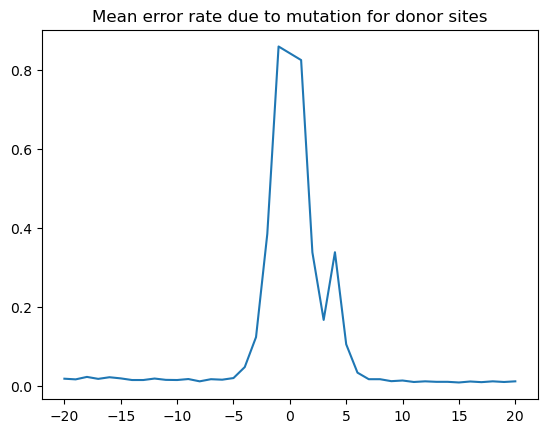

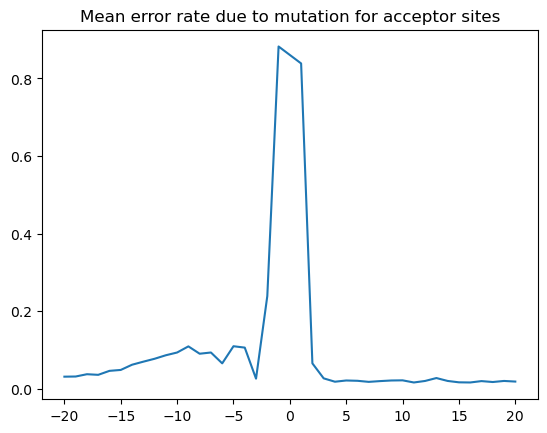

In [54]:
import matplotlib.pyplot as plt 

for type in ("donor", "acceptor"):
    dists = []
    accs = []
    for dist, group in grouping.items():
        mean_acc = sum( (splice_df[splice_df['type']==type][c] < 0).mean() for c in group)  / len(group)
        dists.append(dist)
        accs.append(mean_acc)

    plt.title(f"Mean error rate due to mutation for {type} sites")
    plt.plot(dists, accs)
    plt.show()

In [61]:
acceptor_mapping = {}
for i in range(-20, 0):
    acceptor_mapping[i] = i - 1
acceptor_mapping[1] = -1
for i in range(2, 21):
    acceptor_mapping[i] = i - 2

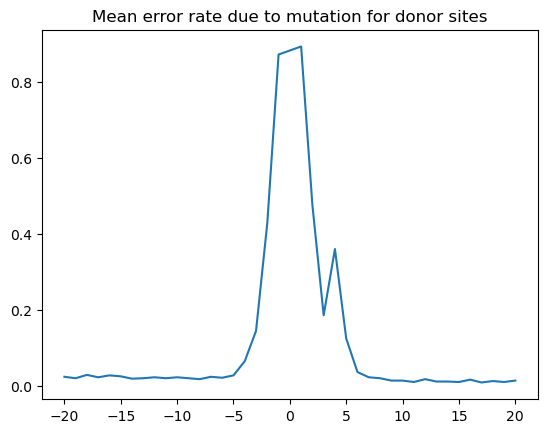

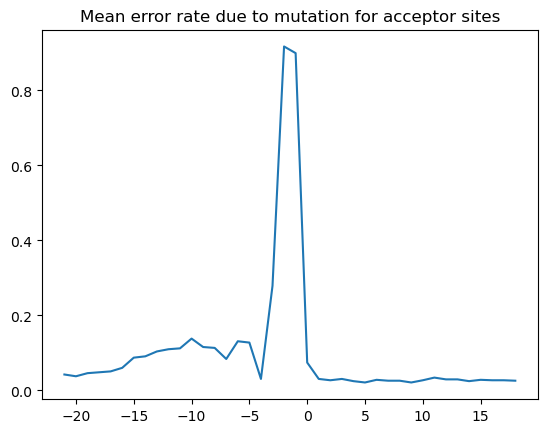

In [62]:
import matplotlib.pyplot as plt 

for type in ("donor", "acceptor"):
    dists = []
    accs = []
    for dist, group in grouping.items():
        mean_acc = max( (splice_df[splice_df['type']==type][c] < 0).mean() for c in group) # / len(group)
        dists.append(dist)
        accs.append(mean_acc)

    plt.title(f"Mean error rate due to mutation for {type} sites")
    if type == "acceptor":
        dists = [acceptor_mapping[d] for d in dists]
    plt.plot(dists, accs)
    plt.show()

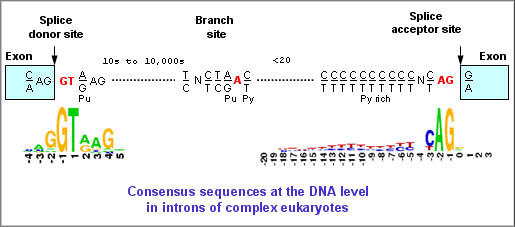

In [60]:
dists

[-20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20]

{-20: -21,
 -19: -20,
 -18: -19,
 -17: -18,
 -16: -17,
 -15: -16,
 -14: -15,
 -13: -14,
 -12: -13,
 -11: -12,
 -10: -11,
 -9: -10,
 -8: -9,
 -7: -8,
 -6: -7,
 -5: -6,
 -4: -5,
 -3: -4,
 -2: -3,
 -1: -2,
 1: -1,
 2: 0,
 3: 1,
 4: 2,
 5: 3,
 6: 4,
 7: 5,
 8: 6,
 9: 7,
 10: 8,
 11: 9,
 12: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 18: 16,
 19: 17,
 20: 18}